<a href="https://colab.research.google.com/github/sdallman/Time_series_model/blob/main/time_series_of_pressure.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecast of pressure data

In [ ]:
# Data manipulation
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
from sklearn.metrics import mean_squared_error
import xgboost as xgb

plt.style.use('fivethirtyeight')

In [ ]:
df= pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Focus/pressure-2022-07-08.csv')
df

,id,client,location,device,pressureA,pressureB,timestamp
0,20814,VCS,Houston,Oxygen,2051,1998,2022-07-07 19:05:01
1,20813,VCS,Houston,Oxygen,2048,1994,2022-07-07 18:00:45
2,20812,VCS,Houston,Oxygen,2042,1990,2022-07-07 16:56:29
3,20811,VCS,Houston,Oxygen,2047,1996,2022-07-07 15:52:13
4,20810,VCS,Houston,Oxygen,2050,1998,2022-07-07 14:47:57
...,...,...,...,...,...,...,...
18238,2213,VCS,Houston,Oxygen,1964,2272,2020-02-01 08:14:27
18239,2212,VCS,Houston,Oxygen,1982,2292,2020-02-01 07:10:11
18240,2211,VCS,Houston,Oxygen,1972,2281,2020-02-01 06:05:47
18241,2210,VCS,Houston,Oxygen,1974,2283,2020-02-01 05:01:31


## Convert the columns with date information into a datetime format

In [ ]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

## Remove data to only have one value per day

In [ ]:
pressureA = df.groupby(df['timestamp'].dt.date)['pressureA'].min().reset_index()
pressureB = df.groupby(df['timestamp'].dt.date)['pressureB'].min().reset_index()

df = pressureA.join(pressureB.set_index('timestamp'), on='timestamp')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 831 entries, 0 to 830
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  831 non-null    object
 1   pressureA  831 non-null    int64 
 2   pressureB  831 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 19.6+ KB


In [ ]:
#Move Timestamp to index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.set_index('timestamp')
df.head()

,pressureA,pressureB
timestamp,,
2020-02-01,1957,2266
2020-02-02,1970,2275
2020-02-03,1940,2287
2020-02-04,1905,2293
2020-02-05,1769,2283


## Split the data into train and test


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 831 entries, 2020-02-01 to 2022-07-07
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   pressureA  831 non-null    int64
 1   pressureB  831 non-null    int64
dtypes: int64(2)
memory usage: 19.5 KB


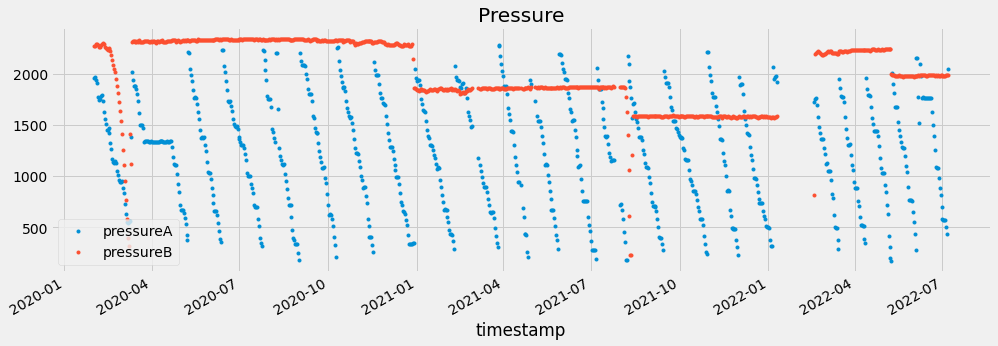

In [ ]:
df.plot(style='.', figsize=(15,5), title='Pressure')
plt.show()

In [ ]:
train = df.loc[df.index < '2022-01-01']
test = df.loc[df.index >= '2022-01-01']

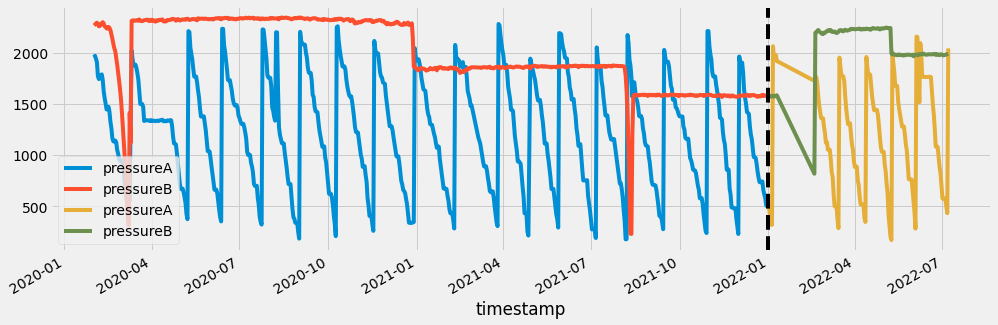

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label="Training Set")
test.plot(ax=ax, label="Testing Set")
ax.axvline('01-01-2022', color='black', ls='--')
plt.show()

# Feature additions

In [ ]:
def create_features(df):
  """
  Create time series features based on time series index
  """
  df = df.copy()
  #df['month'] = df.index.month
  #df['day'] = df.index.day
  df['day_of_week'] = df.index.day_of_week
  return df
 

In [ ]:
def create_lags(df):
  """
  Create time series lags for the training data
  """
  df['pressureA_lag1'] = df['pressureA'].shift(1)
  df['pressureB_lag1'] = df['pressureB'].shift(1)
  df['pressureA_lag2'] = df['pressureA'].shift(2)
  df['pressureB_lag2'] = df['pressureB'].shift(2)
  df['pressureA_lag3'] = df['pressureA'].shift(3)
  df['pressureB_lag3'] = df['pressureB'].shift(3)
  #df = df.dropna()
  #df['pressureA_lag1'].apply(np.int64)
  #df['pressureB_lag1'].apply(np.int64)
  return df

In [ ]:
df = create_features(df)
df = create_lags(df)

In [ ]:
df.head()



,pressureA,pressureB,day_of_week,pressureA_lag1,pressureB_lag1,pressureA_lag2,pressureB_lag2,pressureA_lag3,pressureB_lag3
timestamp,,,,,,,,,
2020-02-01,1957,2266,5,NaN,NaN,NaN,NaN,NaN,NaN
2020-02-02,1970,2275,6,1957.0,2266.0,NaN,NaN,NaN,NaN
2020-02-03,1940,2287,0,1970.0,2275.0,1957.0,2266.0,NaN,NaN
2020-02-04,1905,2293,1,1940.0,2287.0,1970.0,2275.0,1957.0,2266.0
2020-02-05,1769,2283,2,1905.0,2293.0,1940.0,2287.0,1970.0,2275.0


In [ ]:
train = create_features(train)
test = create_features(test)
train = create_lags(train)
test = create_lags(test)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 681 entries, 2020-02-01 to 2021-12-31
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pressureA       681 non-null    int64  
 1   pressureB       681 non-null    int64  
 2   day_of_week     681 non-null    int64  
 3   pressureA_lag1  680 non-null    float64
 4   pressureB_lag1  680 non-null    float64
 5   pressureA_lag2  679 non-null    float64
 6   pressureB_lag2  679 non-null    float64
 7   pressureA_lag3  678 non-null    float64
 8   pressureB_lag3  678 non-null    float64
dtypes: float64(6), int64(3)
memory usage: 53.2 KB


# Create our model.

In [ ]:
train.columns

Index(['pressureA', 'pressureB', 'day_of_week', 'pressureA_lag1',
       'pressureB_lag1', 'pressureA_lag2', 'pressureB_lag2', 'pressureA_lag3',
       'pressureB_lag3'],
      dtype='object')

In [ ]:
FEATURES = [ 'day_of_week', 'pressureA_lag1', 'pressureA_lag2', 'pressureA_lag3' ] 
TARGET = 'pressureA'

In [ ]:
X_train = train[FEATURES]
y_train = train[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

In [ ]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                       n_estimators=2000, 
                       early_stopping_rounds=10,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[14:53:10] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1322.05219	validation_1-rmse:1298.28197
[100]	validation_0-rmse:529.34432	validation_1-rmse:552.95530
[200]	validation_0-rmse:259.76438	validation_1-rmse:350.55393
[300]	validation_0-rmse:178.93393	validation_1-rmse:309.09922
[362]	validation_0-rmse:152.97410	validation_1-rmse:306.11716


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=10, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=2000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

In [ ]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=FEATURES,
             columns=['importance'])

In [ ]:
fi

,importance
day_of_week,0.112944
pressureA_lag1,0.680991
pressureA_lag2,0.116221
pressureA_lag3,0.089844


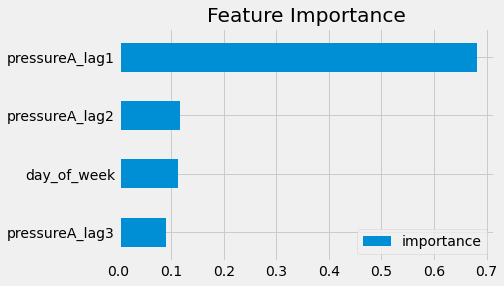

In [ ]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Forecast on Test

In [ ]:
test['prediction'] = reg.predict(X_test)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 831 entries, 2020-02-01 to 2022-07-07
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pressureA       831 non-null    int64  
 1   pressureB       831 non-null    int64  
 2   day_of_week     831 non-null    int64  
 3   pressureA_lag1  830 non-null    float64
 4   pressureB_lag1  830 non-null    float64
 5   pressureA_lag2  829 non-null    float64
 6   pressureB_lag2  829 non-null    float64
 7   pressureA_lag3  828 non-null    float64
 8   pressureB_lag3  828 non-null    float64
dtypes: float64(6), int64(3)
memory usage: 64.9 KB


In [ ]:

df_prediction = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

In [ ]:
#df.drop(columns=['prediction_x', 'prediction_y'], inplace=True)
df_prediction.tail()

,pressureA,pressureB,day_of_week,pressureA_lag1,pressureB_lag1,pressureA_lag2,pressureB_lag2,pressureA_lag3,pressureB_lag3,prediction
timestamp,,,,,,,,,,
2022-07-03,575,1978,6,571.0,1973.0,576.0,1980.0,694.0,1984.0,579.746033
2022-07-04,574,1978,0,575.0,1978.0,571.0,1973.0,576.0,1980.0,549.857178
2022-07-05,500,1984,1,574.0,1978.0,575.0,1978.0,571.0,1973.0,549.857178
2022-07-06,432,1986,2,500.0,1984.0,574.0,1978.0,575.0,1978.0,454.626740
2022-07-07,2042,1990,3,432.0,1986.0,500.0,1984.0,574.0,1978.0,449.105713


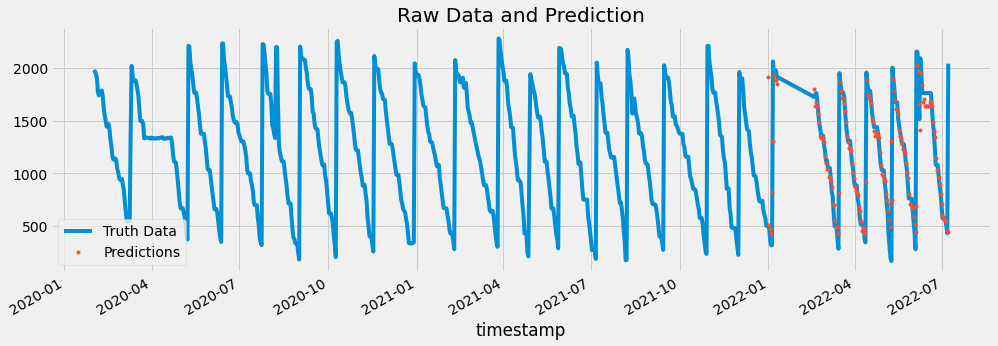

In [ ]:
ax = df_prediction[['pressureA']].plot(figsize=(15,5))
df_prediction['prediction'].plot(ax=ax, style=".")
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [ ]:
score = np.sqrt(mean_squared_error(test['pressureA'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')

RMSE Score on Test set: 305.87


# Predict into the future

In [ ]:
# Retrain on all data

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=3000,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[14:53:51] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:1317.83655
[100]	validation_0-rmse:532.92964
[200]	validation_0-rmse:271.66544
[300]	validation_0-rmse:195.41378
[400]	validation_0-rmse:162.13691
[500]	validation_0-rmse:141.31609
[600]	validation_0-rmse:127.19664
[700]	validation_0-rmse:116.80174
[800]	validation_0-rmse:106.24646
[900]	validation_0-rmse:97.15318
[1000]	validation_0-rmse:89.69134
[1100]	validation_0-rmse:84.11575
[1200]	validation_0-rmse:79.73826
[1300]	validation_0-rmse:75.73786
[1400]	validation_0-rmse:71.94666
[1500]	validation_0-rmse:68.71381
[1600]	validation_0-rmse:66.11498
[1700]	validation_0-rmse:63.80379
[1800]	validation_0-rmse:62.11543
[1900]	validation_0-rmse:60.71374
[2000]	validation_0-rmse:59.11464
[2100]	validation_0-rmse:57.61081
[2200]	validation_0-rmse:55.97207
[2300]	validation_0-rmse:54.40282
[2400]	validation_0-rmse:52.78943
[2500]	validation_0-rmse:50.95673

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.01, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=3000,
             n_jobs=0, num_parallel_tree=1, objective='reg:linear',
             predictor='auto', random_state=0, reg_alpha=0, ...)

In [ ]:
df.index.max()

Timestamp('2022-07-07 00:00:00')

In [ ]:
df.tail()

,pressureA,pressureB,day_of_week,pressureA_lag1,pressureB_lag1,pressureA_lag2,pressureB_lag2,pressureA_lag3,pressureB_lag3
timestamp,,,,,,,,,
2022-07-03,575,1978,6,571.0,1973.0,576.0,1980.0,694.0,1984.0
2022-07-04,574,1978,0,575.0,1978.0,571.0,1973.0,576.0,1980.0
2022-07-05,500,1984,1,574.0,1978.0,575.0,1978.0,571.0,1973.0
2022-07-06,432,1986,2,500.0,1984.0,574.0,1978.0,575.0,1978.0
2022-07-07,2042,1990,3,432.0,1986.0,500.0,1984.0,574.0,1978.0


In [ ]:
data = {'timestamp': '2022-07-07 19:05:01',
        'pressureA': 2042,	
        'pressureB': 1990,
        'day_of_week': 3, 
        'pressureA_lag1': 432, 
        'pressureA_lag2': 500, 
        'pressureA_lag3': 574}



data_df = pd.DataFrame(data,index=[0])
data_df['timestamp'] = pd.to_datetime(data_df['timestamp']).dt.date
data_df = data_df.set_index('timestamp')
data_df

,pressureA,pressureB,day_of_week,pressureA_lag1,pressureA_lag2,pressureA_lag3
timestamp,,,,,,
2022-07-07,2042,1990,3,432,500,574


In [ ]:
# Create future dataframe
future_date = pd.date_range(start=data_df.index.min(), periods=30, freq='D')
future_df = pd.DataFrame(index=future_date, columns=['pressureA', 'pressureB',	'day_of_week',	'pressureA_lag1',	'pressureA_lag2',	'pressureA_lag3'])
future_df = future_df.astype(float)
future_df.head()

,pressureA,pressureB,day_of_week,pressureA_lag1,pressureA_lag2,pressureA_lag3
2022-07-07,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-08,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-09,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-10,NaN,NaN,NaN,NaN,NaN,NaN
2022-07-11,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# insert data into dataframe
future_df.iloc[0] = data_df.iloc[0]
future_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 30 entries, 2022-07-07 to 2022-08-05
Freq: D
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pressureA       1 non-null      float64
 1   pressureB       1 non-null      float64
 2   day_of_week     1 non-null      float64
 3   pressureA_lag1  1 non-null      float64
 4   pressureA_lag2  1 non-null      float64
 5   pressureA_lag3  1 non-null      float64
dtypes: float64(6)
memory usage: 1.6 KB


In [ ]:
# shift data for 1st prediction of next date
future_df.iloc[1]['pressureA_lag3'] = future_df.iloc[0]['pressureA_lag2']
future_df.iloc[1]['pressureA_lag2'] = future_df.iloc[0]['pressureA_lag1']
future_df.iloc[1]['pressureA_lag1'] = future_df.iloc[0]['pressureA']
#drop 1st row
future_df.drop(index=future_df.iloc[0].name, inplace=True)
future_df.drop(columns=['pressureA', 'pressureB'], inplace=True)
future_df = create_features(future_df)

In [ ]:
future_df

,day_of_week,pressureA_lag1,pressureA_lag2,pressureA_lag3
2022-07-08,4,2042.0,432.0,500.0
2022-07-09,5,NaN,NaN,NaN
2022-07-10,6,NaN,NaN,NaN
2022-07-11,0,NaN,NaN,NaN
2022-07-12,1,NaN,NaN,NaN
2022-07-13,2,NaN,NaN,NaN
2022-07-14,3,NaN,NaN,NaN
2022-07-15,4,NaN,NaN,NaN
2022-07-16,5,NaN,NaN,NaN
2022-07-17,6,NaN,NaN,NaN


In [ ]:
prediction = pd.DataFrame(index=future_df.index, columns=['prediction'])


In [ ]:
prediction.head(30)

,prediction
2022-07-08,1867.71521
2022-07-09,1857.212891
2022-07-10,1851.925537
2022-07-11,1784.874756
2022-07-12,1716.226196
2022-07-13,1652.407104
2022-07-14,1534.937378
2022-07-15,1500.351807
2022-07-16,1493.955078
2022-07-17,1449.578613


In [ ]:

for i in range(len(future_df)):
  temp1 = pd.DataFrame(future_df.iloc[i]).transpose()
  
 
  prediction.iloc[i] = reg.predict(temp1)
  if i != len(future_df)-1:
    j = i+1
    future_df.iloc[j,1] = prediction.iloc[i,0]
    future_df.iloc[j,2] = future_df.iloc[i,1]
    future_df.iloc[j,3] = future_df.iloc[i,2]
    
  

# Save model

In [ ]:
reg.save_model('model.json')

In [ ]:
reg_new = xgb.XGBRegressor()
reg_new.load_model("model.json")